# Generating biophysically detailed multi-compartmental models

This tutorial provides a walkthrough on how to use ISF in order to generate biophysically detailed multi-comparmental models that are consistent with empirical responses. To do this, you will need:

1. A neuron morphology in the `.hoc` format.
2. Empirical data on the neuron's biophysical expression.
3. Empirical constraints on the electrophysiological response to input stimuli.

ISF provides two ways of generating multi-compartmental neuron models:


|   |Algorithm | Pros | Cons
|---|---|---|---|
|1.|[Multi-Objective Evolutionary Algorithm (MOEA)](../../../biophysics_fitting/MOEA_EH_minimal/__init__.py) | No a priori requirements | Does not explore the full diversity of possible BDMs|
|2.|[Exploration algorithm](../../../biophysics_fitting/exploration_from_seedpoint/__init__.py) | Explores the full biophysical diversity of possible BDMs | Requires a seedpoint|

Below, we go over an example on how to generate neuron models using both approaches for a Layer 5 Pyramidal Tract (L5PT) neuron. Let's set up a database for the results generated during this tutorial.

In [1]:
import Interface as I
from getting_started import getting_started_dir, tutorial_output_dir

example_data_dir = I.os.path.join(getting_started_dir, 'example_data')
db = I.DataBase(tutorial_output_dir)
model_db = I.DataBase(getting_started_dir, "example_data", "simulation_data", "biophysics", "example_models")

[INFO] distributed_lock: trying to connect to distributed locking server {'config': {'hosts': 'somalogin02:33333'}, 'type': 'zookeeper'}
[INFO] distributed_lock: success!
[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/.pixi/envs/default/lib/python3.8/site-packages/pandas_msgpack/packers.py:78: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


[INFO] l5pt: Loading mechanisms:


--No graphics will be displayed.


[INFO] ISF: Current version: heads/docs
[INFO] ISF: Current pid: 63761
[WARNING] ISF: Could not load linked views



[INFO] ISF: Loaded modules with __version__ attribute are:
IPython: 8.12.2, Interface: heads/docs, PIL: 10.4.0, _brotli: 1.1.0, _csv: 1.0, _ctypes: 1.1.0, _curses: b'2.2', _decimal: 1.70, argparse: 1.1, backcall: 0.2.0, blosc: 1.11.1, bluepyopt: 1.9.126, brotli: 1.1.0, certifi: 2024.08.30, cffi: 1.17.0, charset_normalizer: 3.4.0, click: 7.1.2, cloudpickle: 3.1.0, colorama: 0.4.6, comm: 0.2.2, csv: 1.0, ctypes: 1.1.0, cycler: 0.12.1, cytoolz: 0.12.3, dash: 2.18.1, dask: 2.30.0, dateutil: 2.9.0, deap: 1.4, debugpy: 1.8.5, decimal: 1.70, decorator: 5.1.1, defusedxml: 0.7.1, distributed: 2.30.0, distutils: 3.8.20, django: 1.8.19, entrypoints: 0.4, executing: 2.1.0, flask: 1.1.4, fsspec: 2024.10.0, future: 1.0.0, greenlet: 3.1.1, idna: 3.10, ipaddress: 1.0, ipykernel: 6.29.5, ipywidgets: 8.1.5, itsdangerous: 1.1.0, jedi: 0.19.1, jinja2: 2.11.3, joblib: 1.4.2, json: 2.0.9, jup

## Multi-Objective Evolutionary Algorithm

This section will guide you through using ISF to create neuron models from scratch using a Multi-Objective Evolutionary Optimization algorithm (MOEA) called [BluePyOpt](https://github.com/BlueBrain/BluePyOpt).

### Empirical limits for biophysical parameters

In [2]:
from biophysics_fitting.hay_complete_default_setup import get_feasible_model_params

params = get_feasible_model_params().drop('x', axis=1)
params.index = [e.replace('CaDynamics_E2', 'CaDynamics_E2_v2') for e in params.index]
params.index = 'ephys.' + params.index

In addition to the conductance of the ion channels, two important free parameters need to be added in order to find models for an L5PT:
- The spatial distribution of $SK_V3.1$ channels along the apical dendrite. These are modeled here to slope off from the soma towards the end of the apical dendrite, consistent with Schaefer et al. (2007) (https://doi.org/10.1113/jphysiol.2006.122564)

- The thickness of the apical dendrite. Why this is added as a free parameter is explained in [this auxiliary notebook](../auxiliary%20notebooks/A.0%20The%20Barrel%20Cortex.ipynb)

In [3]:
params = params.append(
    I.pd.DataFrame({
        'ephys.SKv3_1.apic.slope': {
            'min': -3,
            'max': 0
        },
        'ephys.SKv3_1.apic.offset': {
            'min': 0,
            'max': 1
        }
    }).T)
params = params.append(
    I.pd.DataFrame({
        'min': .333,
        'max': 3
    }, index=['scale_apical.scale']))


params = params.sort_index()
print("Empirical limits for biological parameters")
params

Empirical limits for biological parameters


,min,max
ephys.CaDynamics_E2_v2.apic.decay,20.00000,200.00000
ephys.CaDynamics_E2_v2.apic.gamma,0.00050,0.05000
ephys.CaDynamics_E2_v2.axon.decay,20.00000,1000.00000
ephys.CaDynamics_E2_v2.axon.gamma,0.00050,0.05000
ephys.CaDynamics_E2_v2.soma.decay,20.00000,1000.00000
ephys.CaDynamics_E2_v2.soma.gamma,0.00050,0.05000
ephys.Ca_HVA.apic.gCa_HVAbar,0.00000,0.00500
ephys.Ca_HVA.axon.gCa_HVAbar,0.00000,0.00100
ephys.Ca_HVA.soma.gCa_HVAbar,0.00000,0.00100
ephys.Ca_LVAst.apic.gCa_LVAstbar,0.00000,0.20000


### Database setup

The MOEA algorithm expects a database containing methods that set up Simulator and Evaluator objects. Let's create these methods.
Here, you can set up which input stimuli will be run, and how they will be evaluated. We have already created such simulation setup and evaluation methods for L5PTs consisten with [Hay et al. (2011)](https://doi.org/10.1371/journal.pcbi.1002107
) in [hay_complete_default_setup](../../../biophysics_fitting/hay_complete_default_setup.py) and [L5tt_parameter_setup](../../../biophysics_fitting/L5tt_parameter_setup.py)

In [4]:
from biophysics_fitting.L5tt_parameter_setup import get_L5tt_template_v2
import biophysics_fitting.hay_complete_default_setup as hay_setup

def scale_apical(cell_param, params):
    assert(len(params) == 1)
    cell_param.cell_modify_functions.scale_apical.scale = params['scale']
    return cell_param

def get_fixed_params(db_setup):
    """
    Configure the fixed params and return
    """
    fixed_params = db_setup['fixed_params']
    fixed_params['morphology.filename'] = db_setup['morphology'].get_file(
        'hoc')
    return fixed_params

def get_Simulator(db_setup, step=False):
    """
    Configure the Simulator object and return
    """
    fixed_params = db_setup['get_fixed_params'](db_setup)
    s = hay_setup.get_Simulator(
        I.pd.Series(fixed_params),
        step=step)
    s.setup.cell_param_generator = get_L5tt_template_v2
    s.setup.cell_param_modify_funs.append(
        ('scale_apical', scale_apical)
        )
    s.setup.params_modify_funs_after_cell_generation = []
    return s

def get_Evaluator(db_setup, step=False):
    """
    No additional configuration is needed for the Evaluator, simply return biophysics_fitting.L5tt_parameter_setup.get_Evaluator
    """
    return hay_setup.get_Evaluator(step=step)

def get_Combiner(db_setup, step=False):
    """
    No additional configuration is needed for the Combiner, simply return biophysics_fitting.L5tt_parameter_setup.get_Combiner
    """
    return hay_setup.get_Combiner(step=step)

Now, the database for optimization can be set up as seen below.

In [5]:
def set_up_db_for_MOEA(db, morphology_id='89', morphology="", step=False):
    """
    Set up a DataBase for MOEA.

    Args:
        db: a DataBase object
        morphology_id: name of the morphology
        morphology: path to a .hoc morphology file
        step: whether or not to perform step current injections

    Returns:
        data_base.DataBase: a database containing:
            - fixed_params
            - get_fixed_params
            - get_Simulator
            - get_Evaluator
            - get_Combiner
            - the morphology file
    """
    from data_base.IO.LoaderDumper import pandas_to_pickle, to_cloudpickle
    db.create_sub_db(morphology_id)

    db[morphology_id].create_managed_folder('morphology')
    I.shutil.copy(
        I.os.path.join(
            morphology
        ), db[morphology_id]['morphology'].join(
            morphology.split(I.os.sep)[-1]
        ))

    db[morphology_id]['fixed_params'] = {
        'BAC.hay_measure.recSite': 294.8203371921156,   # recording site on the apical dendrite for BAC
        'BAC.stim.dist': 294.8203371921156,             # stimulus injection site on the apical dendrite for BAC
        'bAP.hay_measure.recSite1': 294.8203371921156,  # recording site 1 on the apical dendrite for bAP
        'bAP.hay_measure.recSite2': 474.8203371921156,  # recording site 2 on the apical dendrite for bAP
        'hot_zone.min_': 384.8203371921156,             # calcium zone start
        'hot_zone.max_': 584.8203371921156,             # calcium zone end
        'hot_zone.outsidescale_sections': [23,24,25,26,27,28,29,31,32,33,34,35,37,38,40,42,43,44,46,48,50,51,52,54,56,58,60],
        'morphology.filename': None
        }

    db[morphology_id]['get_fixed_params'] = get_fixed_params
    db[morphology_id].set('params', params, dumper=pandas_to_pickle)
    db[morphology_id].set('get_Simulator',
                      I.partial(get_Simulator, step=step),
                      dumper=to_cloudpickle)
    db[morphology_id].set('get_Evaluator',
                      I.partial(get_Evaluator, step=step),
                      dumper=to_cloudpickle)
    db[morphology_id].set('get_Combiner',
                      I.partial(get_Combiner, step=step),
                      dumper=to_cloudpickle)

    return db

Let's copy over a morphology and initialize our DataBase for the optimization run

In [6]:
morphology_path = I.os.path.join(
    example_data_dir, 
    "anatomical_constraints", 
    "89_L5_CDK20050712_nr6L5B_dend_PC_neuron_transform_registered_C2.hoc")

In [7]:
db = set_up_db_for_MOEA(
    db,
    morphology_id="89",
    morphology=morphology_path,
    step=False
    )
db.ls(max_lines_per_key=10)

Located at /gpfs/soma_fs/home/meulemeester/ISF_tutorial_output
ISF_tutorial_output
└── 89
    ├── params
    ├── get_Simulator
    ├── morphology
    ├── get_fixed_params
    ├── fixed_params
    ├── get_Evaluator
    └── get_Combiner


/bin/sh: conda: command not found


### Run the optimization algorithm

We're now ready to run the optimization algorithm.

In [10]:
seedpoint = 42

population = I.bfit_start_run(
    db['89'], 
    n=seedpoint,
    client=I.get_client(), 
    offspring_size=10,      # Low amount of offspring just as an example 
    pop=None,               # adapt this to the output population of the previous run to continue where you left off
    continue_cp=False,      # If you want to continue a preivoius run, set to True
    max_ngen=1              # run for just 1 generation
    )

starting multi objective optimization with 5 objectives and 35 parameters


The results are written out after each generation. We have an offspring size of $10$, so we will find 10 proposed biophysical models in generation $1$ of our seedpoint

### Inspecting the optimizer results

As the optimization algorithm did not run for very long, they likely will not produce very good results:

In [11]:
population = db['89'][str(seedpoint)]['1']
objectives = population.drop(params.index, axis=1)
objectives

[WARNING] utils: No index name dtype found in meta file. Index name will be string format. Verify if the column is the desired dtype when resetting the index.


,BAC_ahpdepth,BAC_APheight,BAC_ISI,BAC_caSpike_height,BAC_caSpike_width,BAC_spikecount,bAP_spikecount,bAP_APheight,bAP_APwidth,bAP_att2,bAP_att3
0,243.267088,243.267088,243.267088,243.267088,243.267088,243.267088,247.592556,247.592556,247.592556,247.592556,247.592556
1,110.300383,110.300383,110.300383,110.300383,110.300383,110.300383,0.000000,2.582321,2.380198,2.772171,2.995927
2,240.231650,240.231650,240.231650,240.231650,240.231650,240.231650,246.546398,246.546398,246.546398,246.546398,246.546398
3,189.144036,189.144036,189.144036,189.144036,189.144036,189.144036,0.000000,4.957973,2.326879,0.821165,1.793884
4,247.505286,247.505286,247.505286,247.505286,247.505286,247.505286,249.101821,249.101821,249.101821,249.101821,249.101821
5,248.174632,248.174632,248.174632,248.174632,248.174632,248.174632,249.350281,249.350281,249.350281,249.350281,249.350281
6,121.596667,121.596667,121.596667,121.596667,121.596667,121.596667,0.000000,3.530442,2.140648,3.881070,5.466929
7,245.625295,245.625295,245.625295,245.625295,245.625295,245.625295,248.501893,248.501893,248.501893,248.501893,248.501893
8,247.462340,247.462340,247.462340,247.462340,247.462340,247.462340,249.037219,249.037219,249.037219,249.037219,249.037219
9,242.344034,242.344034,242.344034,242.344034,242.344034,242.344034,247.575373,247.575373,247.575373,247.575373,247.575373


Most values are about $250 \sigma$ removed from the empirical mean, but some objectives are already quite close!
What is the spread on the empirical data?

In [12]:
from biophysics_fitting.hay_complete_default_setup import get_hay_problem_description
empirical_data = get_hay_problem_description()
empirical_data = empirical_data[empirical_data['objective'] \
                                .isin(objectives.columns)] \
                                .set_index("objective") \
                                .loc[objectives.columns]
print("Empirical distribution for physiology objectives")
empirical_data

Empirical distribution for physiology objectives


,feature,mean,std,stim_name,stim_type
BAC_ahpdepth,AHP_depth_abs,-65.000,4.0000,BAC,BAC
BAC_APheight,AP_height,25.000,5.0000,BAC,BAC
BAC_ISI,BAC_ISI,9.901,0.8517,BAC,BAC
BAC_caSpike_height,BAC_caSpike_height,6.730,2.5400,BAC,BAC
BAC_caSpike_width,BAC_caSpike_width,37.430,1.2700,BAC,BAC
BAC_spikecount,Spikecount,3.000,0.0100,BAC,BAC
bAP_spikecount,Spikecount,1.000,0.0100,bAP,bAP
bAP_APheight,AP_height,25.000,5.0000,bAP,bAP
bAP_APwidth,AP_width,2.000,0.5000,bAP,bAP
bAP_att2,BPAPatt2,45.000,10.0000,bAP,bAP


So $250\ \sigma$ is obviously quite far away from the empirical data. Then again, the model did not run for very long.
In general, the initial models proposed by the evolutionary algorithm do not do reproduce empirically observed responses, and are quite far off. It takes a lot more than an offspring size of $10$ and a single generation to get close to a model that reproduces empirically observed responses.

To finalize the optimization, let's see how many of the objectives got close to the empirical mean.

Text(0.5, 0, 'amount of $\\sigma$ from empirical mean')

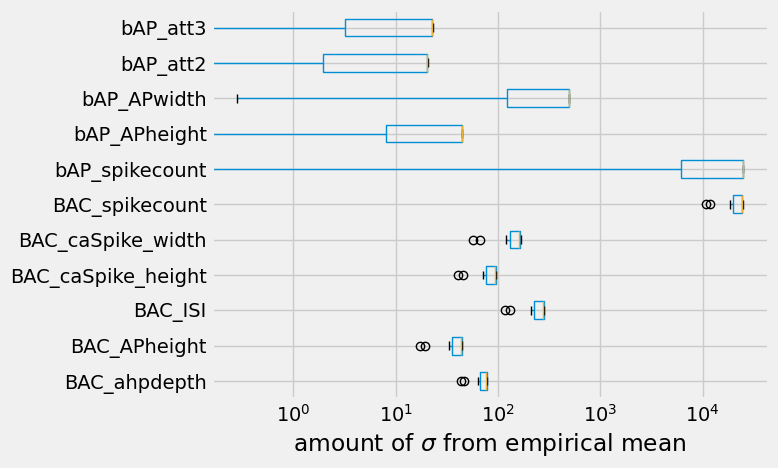

In [13]:
%matplotlib inline
I.plt.style.use("fivethirtyeight")
diff = (objectives - empirical_data['mean']) / empirical_data["std"]
ax = diff.plot.box(vert=False)
ax.set_xscale('log')
ax.set_xlabel("amount of $\sigma$ from empirical mean")

See [the previous tutorial](./1.2%20Evaluation.ipynb) for more information on how to evaluate biophysically detailed single-cell models.

## Exploration from seedpoint

Assuming that we have a biophysical model that performs well on **all** objectives, it is possible to continuously make variations on the biophysical parameters while keeping the objectives in-distribution.

This is conveniently packaged in [`biophysics_fitting.exploration_from_seedpoint`](../../../biophysics_fitting/exploration_from_seedpoint/__init__.py).

In [14]:
if not I.os.path.exists(I.os.path.join(db["89"].basedir, 'RW_exploration_example')):
    db["89"].create_managed_folder('RW_exploration_example')

We provide some working models for this morphology below. 

In [15]:
db["example_models"]

KeyError: "Key example_models not found in keys of db. Keys found: ('89',)"

### Setup the random walk exploration

there are many different kinds of exploration one could do. We will simply use a random walk, as it has proven to be both efficient and capable of broadly sampling the bipohysical parameter space.

In [ ]:
evaluator = db["89"]["get_Evaluator"](db['89'])
simulator = db["89"]["get_Simulator"](db['89'])
biophysical_parameter_ranges = db['89']['params']
example_models = db['example_models']
biophysical_parameter_names = [e for e in example_models.columns if "ephys" in e or e == "scale_apical.scale"]

In [ ]:
from biophysics_fitting.exploration_from_seedpoint.RW import RW
from biophysics_fitting.exploration_from_seedpoint.utils import evaluation_function_incremental_helper
from biophysics_fitting.hay_evaluation import hay_evaluate_bAP, hay_evaluate_BAC

evaluation_function = I.partial(
    evaluation_function_incremental_helper,  # this incremental helper stops the evaluation as soon as a stimulus protocol doesn't work.
    s=simulator,
    e=evaluator,
    stim_order=['bAP', 'BAC']
)

rw = RW(
    param_ranges = biophysical_parameter_ranges,
    df_seeds = example_models[biophysical_parameter_names],
    evaluation_function = evaluation_function,
    MAIN_DIRECTORY = db["89"]['RW_exploration_example'],
    min_step_size = 0.02,
    max_step_size = 0.02,
    checkpoint_every = 1  # This is a lot of IO. Increase this value if you are not merely doing an example.
)

### Run the exploration algorithm

Let's run this for 20 seconds. You can always restart the exploration and it will pick up from where it left off. 

In [ ]:
duration = 30  # in seconds

from time import sleep
from threading import Thread
import multiprocessing

proc = multiprocessing.Process(
    target=rw.run_RW, 
    kwargs={
        'selected_seedpoint': 0,
        'particle_id': 0,
        'seed': 42  # for numpy random seed
    })

# --- run for some time, then kill the process
proc.start()
sleep(duration)
proc.terminate()  # sends a SIGTERM
proc.join()

In [ ]:
from biophysics_fitting.exploration_from_seedpoint.RW_analysis import Load

outdir = db["89"]['RW_exploration_example'].join('0')
l = Load(
    I.get_client(),
    outdir,
    n_particles = 1)

In [ ]:
explored_models = l.get_df().compute()
print("Explored {} new models".format(len(explored_models)))

### Inspecting the exploration results

How much did the exploration actually explore? Let's plot out how much it deviated from it's starting point, relative to the total extent of parameter limits we allowed for

In [ ]:
def normalize(df, mn, mx):
    return (df - mn)/(mx-mn)
    
mn, mx = biophysical_parameter_ranges['min'], biophysical_parameter_ranges['max']
normalized_startpoint = normalize(example_models.iloc[0][biophysical_parameter_names], mn, mx)
normalized_explored_models = normalize(explored_models[biophysical_parameter_names], mn, mx)

# calc exploration relative to startpoint, in % of total allowed parameter limits
d = I.pd.concat([normalized_explored_models, I.pd.DataFrame(normalized_startpoint).T])
d -= normalized_startpoint
d[biophysical_parameter_names] *= 100
d = d.melt(var_name='Biophysical parameter', value_name='Normalized value (%)')

In [ ]:
I.plt.figure(figsize=(5, 10))

ax = I.sns.boxplot(
    data=d,
    y='Biophysical parameter', x='Normalized value (%)',
    whis=100,
    linewidth=1,
    showcaps = False
   )

Let's check what the resulting voltage traces look like

In [ ]:
delayeds = [
    I.dask.delayed(simulator.run)(p, 'BAC') 
    for _, p in explored_models[biophysical_parameter_names].iterrows()
    ]
f = I.get_client().compute(delayeds)

In [ ]:
responses = [f_.result() for f_ in f]
BAC_responses = [response['BAC.hay_measure'] for response in responses]

In [ ]:
soma_voltages = [
    e['vList'][0] for e in BAC_responses
]
dend_voltages = [
    e['vList'][1] for e in BAC_responses
]
time_points = [
    e['tVec'] for e in BAC_responses
]

In [ ]:
fig, (ax1, ax2) = I.plt.subplots(1, 2, figsize=(15, 5))
colors = I.plt.rcParams['axes.prop_cycle'].by_key()['color']                       
random_model = I.np.random.randint(0, len(BAC_responses))
print("Highlighting model nr. {}".format(random_model))

for t, v in zip(time_points, soma_voltages):
    ax1.plot(t, v, c="silver", lw=3)
ax1.plot(
    time_points[random_model], 
    soma_voltages[random_model], 
    c=colors[0],
    lw=2
    )
ax1.set_title("Soma voltage")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Membrane voltage (mV)")

for t, v in zip(time_points, dend_voltages ):
    ax2.plot(t, v, c='silver', lw=3)
ax2.plot(
    time_points[random_model], 
    dend_voltages[random_model], 
    c=colors[1],
    lw=2
    )
ax2.set_title("Dendritic voltage")
ax2.set_xlabel("Time (ms)")
I.plt.show()

In [ ]:
cell, _ = simulator.get_simulated_cell(
    explored_models[biophysical_parameter_names].iloc[random_model], 
    "BAC")

In [ ]:
from visualize.cell_morphology_visualizer import CellMorphologyVisualizer as CMV

CMV(
    cell,
    t_start=250,
    t_stop=400,
    t_step=1,
    ).animation(
    images_path=db.basedir+'/images',
    color="voltage",
    client=I.get_client(),
    show_legend=True
)